# This file is just toying with some various implementations of Bayesian regression in python

Note - we will need to create some mapping from "Celtics" to "BOS" in order to make use of the team ratings that Willis created.

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np

data = pd.read_csv("../data/shifts_data_final_2018_19.csv")
data.drop(['home_team', 'away_team'], axis = 1, inplace = True)
data.head()

,Unnamed: 0,point_diff_per_100,0,1,2,3,4,5,6,7,...,519,520,521,522,523,524,525,526,527,528
0,0,-0.364583,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.390625,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,-0.723380,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,-0.361690,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.382966,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Toy Example

Below we fit a very small Bayesian regression model with some specified priors (chosen arbitrarily). We regress the first 100 point differentials on the first 100 rows of our shifts dataset, only considering players 0-3. Thus, the dimensionality of this toy example is far smaller than our final model will be, but the methodology should be similar. Of course, we will also need to adjust the priors and make them far more meaningful and player specific as this is the main purpose of this project.

In [31]:
x_df = data.iloc[:,1:6][:10]
x_df.columns = ["point_diff", "p0", "p1", "p2", "p3"]

x = np.array(x_df.iloc[:,1:])
y = np.array(x_df.iloc[:,0])

with pm.Model() as model:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10, testval=1.0)
    intercept = pm.Normal("Intercept", 0, sigma=20)
    x_prior_means = np.array([10, -1, 25, -12])
    x_prior_sigmas = np.array([6,6,6,6])
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = 4)
    
    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y)

    trace = pm.sample(1000, tune = 1000, cores = 1, return_inferencedata = False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma]


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7061662320568101, but should be close to 0.8. Try to increase the number of tuning steps.
There were 351 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.515869532344473, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [30]:
# This plots the distributions for the intercept, error (sigma), and the various x coefficients
import arviz
# pm.plot_posterior(trace)
arviz.summary(trace)

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-5.549,4.668,-15.076,0.169,1.330,0.964,9.0,140.0,1.16
x[0],3.173,3.414,-1.842,10.054,0.691,0.495,24.0,415.0,1.07
x[1],1.683,2.717,-3.432,6.938,0.311,0.301,80.0,421.0,1.04
x[2],7.480,5.886,-0.115,18.348,1.878,1.369,7.0,72.0,1.20
x[3],-5.497,4.581,-14.215,1.007,1.400,1.018,8.0,117.0,1.16
sigma,3.422,2.273,1.056,7.634,0.626,0.453,5.0,15.0,1.31


In [27]:
with model:
    print(arviz.summary(trace).loc['x[0]', 'mean'])

3.173


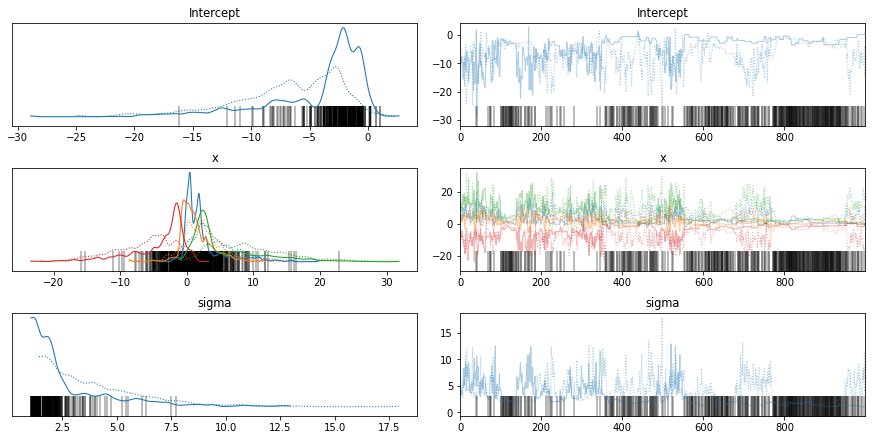

In [24]:
with model:
    arviz.plot_trace(trace)
# plt.show()

In [15]:
# This gives us the mean and sd of each coefficient in a nicely formatted dataframe
# pm.plot_posterior(trace)
# pm.summary(trace, kind="stats")

AttributeError: module 'pymc3' has no attribute 'plot_posterior'

In [126]:
tmp = trace.get_values("x") # This gets all 1000 samples for each variable, then we can get mean and sd from here
np.mean(tmp, axis = 0)
np.std(tmp, axis = 0)
# This was just to verify the results in the above dataframe

array([3.72341036, 2.76280493, 5.59896683, 4.36760699])

# TO DO:

* Make a mapping of player names to ID's so that we can link up contract values as priors as well as potentially box score statistics. Also this will help with interpretability of results - we can do a sanity check to see if Lebron's +/- is better than Alex Caruso's.
* Also find a way to link up team ratings as part of the prior
    * Find some way to combine distributions - so the prior can be a combination of their team rating and their contract value. So for example if the team is bad but the player has a very large contract then his prior should be somewhere between those two values, whereas a big contract on a very good team might just have a very high mean for its prior.
* Run the Bayesian regression and compare results to ridge regression and standard linear regression
* For evaluation - try to create team offensive ratings based on a weighted sum of player +/- for that team and compare these to the true offensive ratings for teams.

Once we have these things set up we should be able to run the regression and get some preliminary results. 

Note - for now, only focus on 2018/19 season

# Player Map

We already have a mapping from index to player id. So we just need a map from player id to player name 

# Priors - we will use a separate notebook to actually do this

We need to have an array of means and an array of standard deviations in order to specify the priors for each of the ~530 NBA players in this regression. So we will need to actually come up with these means and standard deviations before running the regression, store them in arrays that match the indexing of our regression, and then run the regression using these arrays as the priors. 